Импорты библиотек

In [713]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [714]:
print(tf.config.list_physical_devices('GPU'))

[]


Тренировачные и тестовые данные

In [715]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [716]:
test_data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [717]:
train_data.shape

(891, 12)

In [718]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [719]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [720]:
def data_prepare_for_visualisation(data):
        # sort the ages into logical categories
        data["Age"] = data["Age"].fillna(-0.5)
        binsAge = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
        labelsAge = ['Unknown', 'Baby', 'Child', 'Teenager',
                'Student', 'Young Adult', 'Adult', 'Senior']
        data['AgeGroup'] = pd.cut(data["Age"], binsAge, labels=labelsAge)
        labelsPclass = [0,'first','second','third']
        data['PclassStr'] = [labelsPclass[x] for x in data['Pclass'] if x]
        labelsSibSp = ["No", "one", "two", "more"]
        data["SibSp"] = [labelsSibSp[x] if x<4 else labelsSibSp[3] for x in data['Pclass']]
        data['Fare'] = [np.log10(elem) if elem else 0 for elem in data['Fare']]
        data["Cabin"] = data["Cabin"].notnull() * 1
        data = data.fillna({"Embarked": "S"})
        del data['Pclass']
        del data["Name"]
        del data["Ticket"]
        del data["Age"]
        del data["PassengerId"]
        data = data.fillna(0)
        return data

In [721]:
ids = test_data['PassengerId']
train_data = data_prepare_for_visualisation(train_data)
test_data = data_prepare_for_visualisation(test_data)

<AxesSubplot: xlabel='Survived', ylabel='count'>

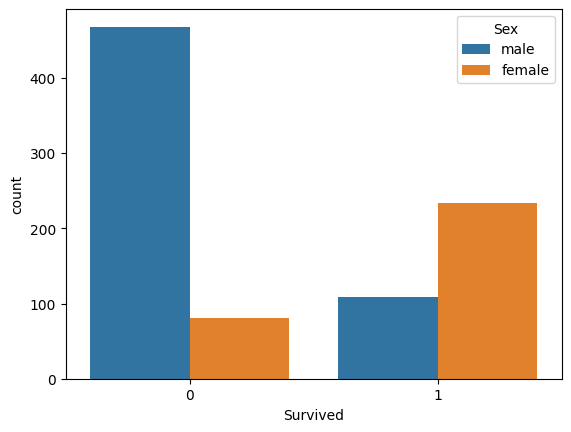

In [722]:
sns.countplot(x='Survived', hue='Sex', data=train_data)

<AxesSubplot: xlabel='Survived', ylabel='count'>

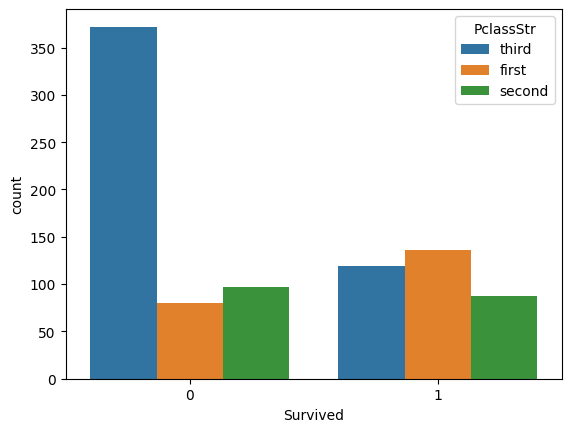

In [723]:
sns.countplot(x='Survived', hue='PclassStr', data=train_data) 

<AxesSubplot: xlabel='Survived', ylabel='count'>

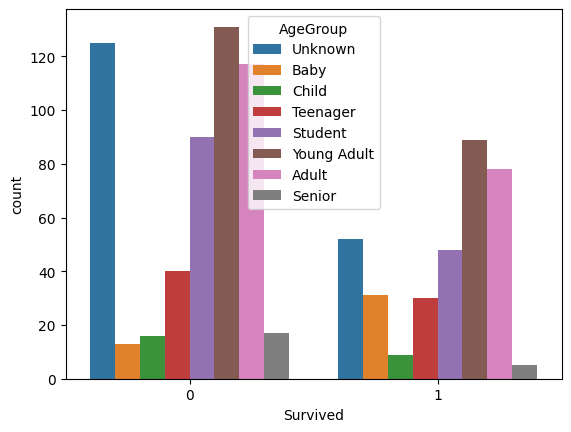

In [724]:
sns.countplot(x='Survived',hue='AgeGroup', data=train_data)

<AxesSubplot: xlabel='Survived', ylabel='count'>

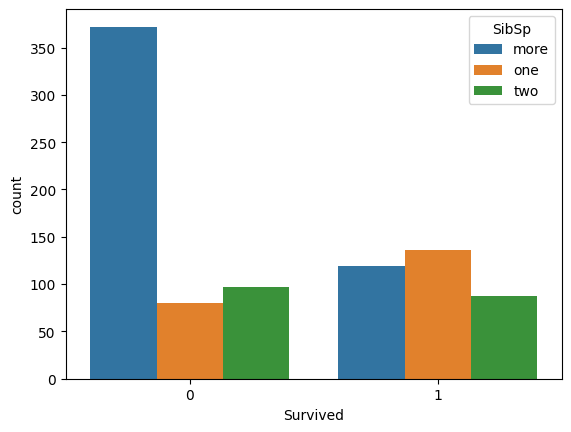

In [725]:
sns.countplot(x='Survived', hue='SibSp', data=train_data) 

<AxesSubplot: xlabel='Survived', ylabel='count'>

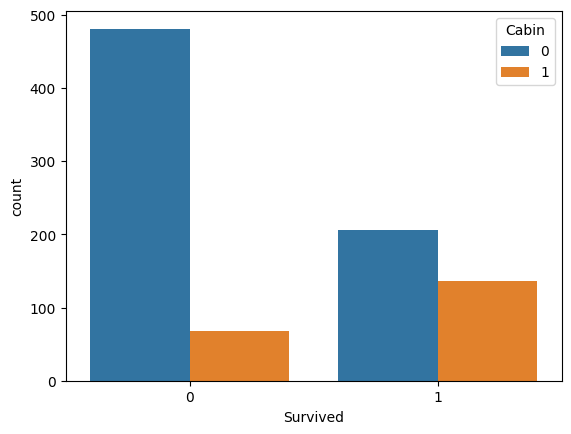

In [726]:
sns.countplot(x='Survived', hue='Cabin', data=train_data)

<AxesSubplot: xlabel='Survived', ylabel='count'>

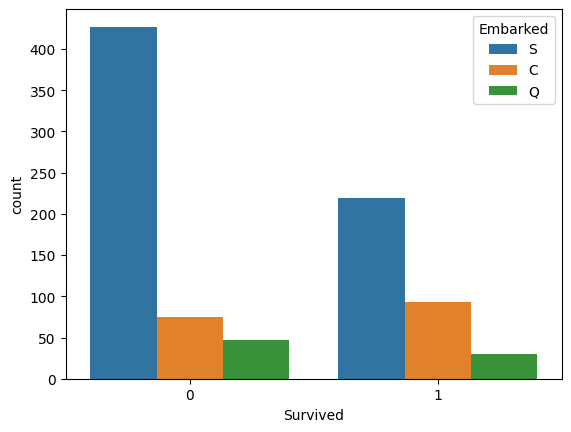

In [727]:
sns.countplot(x='Survived', hue='Embarked', data=train_data)

In [728]:
train_data.head()

,Survived,Sex,SibSp,Parch,Fare,Cabin,Embarked,AgeGroup,PclassStr
0,0,male,more,0,0.860338,0,S,Student,third
1,1,female,one,0,1.852988,1,C,Adult,first
2,1,female,more,0,0.898999,0,S,Young Adult,third
3,1,female,one,0,1.725095,1,S,Young Adult,first
4,0,male,more,0,0.905796,0,S,Young Adult,third


входные данные для сети

In [729]:
features = ['PclassStr', 'Sex', 'AgeGroup', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
target = train_data['Survived']
train = pd.get_dummies(train_data[features])
test = pd.get_dummies(test_data[features])
x_train, x_val, y_train, y_val = train_test_split(
    train, target, test_size=0.2, random_state=0)

In [730]:
test.head()

,Parch,Fare,Cabin,PclassStr_first,PclassStr_second,PclassStr_third,Sex_female,Sex_male,AgeGroup_Unknown,AgeGroup_Baby,...,AgeGroup_Student,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,SibSp_more,SibSp_one,SibSp_two,Embarked_C,Embarked_Q,Embarked_S
0,0,0.893717,0,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
1,0,0.845098,0,0,0,1,1,0,0,0,...,0,0,1,0,1,0,0,0,0,1
2,0,0.986212,0,0,1,0,0,1,0,0,...,0,0,0,1,0,0,1,0,1,0
3,0,0.937643,0,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,1
4,1,1.089464,0,0,0,1,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1


In [731]:
x_train.head()

,Parch,Fare,Cabin,PclassStr_first,PclassStr_second,PclassStr_third,Sex_female,Sex_male,AgeGroup_Unknown,AgeGroup_Baby,...,AgeGroup_Student,AgeGroup_Young Adult,AgeGroup_Adult,AgeGroup_Senior,SibSp_more,SibSp_one,SibSp_two,Embarked_C,Embarked_Q,Embarked_S
140,2,1.183150,0,0,0,1,1,0,1,0,...,0,0,0,0,1,0,0,1,0,0
439,0,1.021189,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
817,1,1.568251,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,1,1,0,0
378,0,0.603415,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
491,0,0.860338,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1


тренируем сеть

In [732]:
randomforest = RandomForestClassifier()

history = randomforest.fit(x_train, y_train)
y_pred_rf = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred_rf, y_val) * 100, 2)
acc_randomforest

82.68

делаем предсказание

In [733]:
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#model.add(layers.Dense(1, activation=tf.keras.activations.get(tf.math.round)))
#model.add(layers.Lambda(lambda x: tf.math.round(x)))
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=[metrics.binary_accuracy])

In [734]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/20
23/23 [==============================] - 1s 7ms/step - loss: 0.6628 - binary_accuracy: 0.6138 - val_loss: 0.6321 - val_binary_accuracy: 0.6145
Epoch 2/20
23/23 [==============================] - 0s 2ms/step - loss: 0.6162 - binary_accuracy: 0.6166 - val_loss: 0.5950 - val_binary_accuracy: 0.6145
Epoch 3/20
23/23 [==============================] - 0s 2ms/step - loss: 0.5859 - binary_accuracy: 0.6180 - val_loss: 0.5601 - val_binary_accuracy: 0.6145
Epoch 4/20
23/23 [==============================] - 0s 2ms/step - loss: 0.5608 - binary_accuracy: 0.6292 - val_loss: 0.5328 - val_binary_accuracy: 0.6592
Epoch 5/20
23/23 [==============================] - 0s 2ms/step - loss: 0.5425 - binary_accuracy: 0.7051 - val_loss: 0.5143 - val_binary_accuracy: 0.7821
Epoch 6/20
23/23 [==============================] - 0s 2ms/step - loss: 0.5294 - binary_accuracy: 0.7921 - val_loss: 0.5016 - val_binary_accuracy: 0.8212
Epoch 7/20
23/23 [==============================] - 0s 2ms/step - loss: 0.51

In [735]:
y_pred_m = model.predict(x_val)
y_pred_m = tf.cast(tf.math.round([x[0] for x in y_pred_m]), tf.int64).numpy()
acc_model = round(accuracy_score(y_pred_m, y_val) * 100, 2)
acc_model

6/6 [==============================] - 0s 799us/step


82.68

In [736]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
binary_accuracy_values = history_dict['binary_accuracy']
val_binary_accuracy_values = history_dict['val_binary_accuracy']

epochs = range(1, len(binary_accuracy_values) + 1)

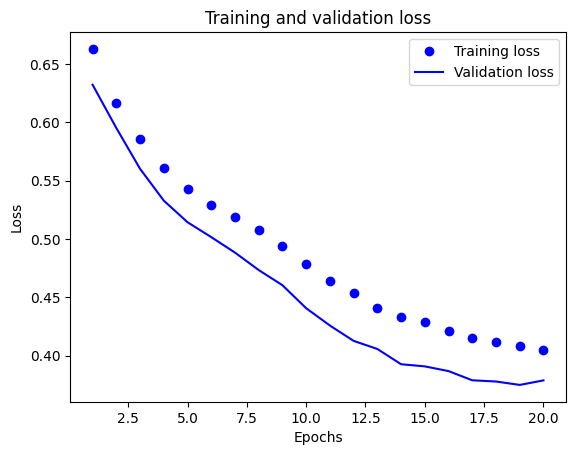

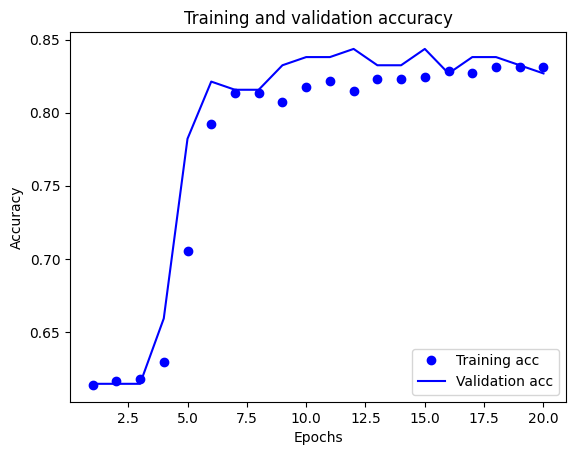

In [737]:
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()
plt.plot(epochs, binary_accuracy_values, 'bo', label='Training acc')
plt.plot(epochs, val_binary_accuracy_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [738]:
predictions_rf = randomforest.predict(test)
predictions_rf

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [739]:
predictions_m = model.predict(test)
predictions_m = tf.cast(tf.math.round([x[0] for x in predictions_m]), tf.int64).numpy()
predictions_m

14/14 [==============================] - 0s 614us/step


array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [740]:
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions_rf})
output.to_csv('resultfile_rf.csv', index=False)
print(acc_randomforest)

82.68


In [741]:
output = pd.DataFrame({'PassengerId': ids, 'Survived': predictions_m})
output.to_csv('resultfile_m.csv', index=False)
print(acc_model)

82.68
